In [1]:
from quests_data import *
from einstein import einstein_crystal

import itertools
from scipy import integrate
from scipy.interpolate import interp1d
from scipy.spatial.distance import cdist

from quests.tools.plotting import savefig
from quests.tools.polyfit import PolynomialRegressor2D, find_zero_points

ROOT_DIR = "../data/A11-Sn"

In [2]:
alpha = pd.read_csv(f"{ROOT_DIR}/ti/alpha.csv", index_col=0)
beta = pd.read_csv(f"{ROOT_DIR}/ti/beta.csv", index_col=0)

spring_k = 2.0
temperature = 200
mass = 118.71
GPa = 1 / 160.21766208
kB = 1 / 8.617333e-5
kJ_mol = 0.01036410

In [3]:
VOLS = [98, 100, 102]
TEMPS = np.arange(200, 351, 25)

In [4]:
def integr(x, y):
    fn = interp1d(x, y, kind="cubic")
    integ, err = integrate.quad(fn, 0.00, 1.00, limit=200)
    return integ

def integr2(x, y):
    x = np.sqrt(x)
    fn = interp1d(x, 2 * x * y, kind="linear")
    integ, err = integrate.quad(fn, 0.00, 1.00, limit=200)
    return integ

In [5]:
results = []
for (v, t) in itertools.product(VOLS, TEMPS):
    _a = alpha.loc[(alpha.folder == v) & (alpha.temperature == t)] 
    _b = beta.loc[(beta.folder == v) & (beta.temperature == t)] 
    f_ein, u_ein, s_ein = einstein_crystal(spring_k=spring_k, temperature=t, mass=mass)
    
    f_alpha = integr2(_a["lambda"], -_a["energy"] + u_ein)
    f_beta = integr2(_b["lambda"], -_b["energy"] + u_ein)
    
    results.append({
        "folder": v,
        "T": t,
        "V_alpha": _a["volume"].iloc[0],
        "V_beta": _b["volume"].iloc[0],
        "U_alpha": _a["energy"].iloc[0],
        "U_beta": _b["energy"].iloc[0],
        "F_ein": f_ein,
        "S_ein": kB * s_ein,
        "U_ein": u_ein,
        "F_alpha": -f_alpha + f_ein,
        "F_beta": -f_beta + f_ein,
        "P_alpha": _a["pressure"].iloc[0],
        "P_beta": _b["pressure"].iloc[0],
    })
    
df = pd.DataFrame(results)

/var/folders/pk/bysbkx9j3993c_vqdsykcn680000gn/T/ipykernel_46810/1650940517.py:9: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integ, err = integrate.quad(fn, 0.00, 1.00, limit=200)


In [6]:
df["G_alpha"] = df["F_alpha"] + df["P_alpha"] * df["V_alpha"] * GPa
df["G_beta"] = df["F_beta"] + df["P_beta"] * df["V_beta"] * GPa
df["dG"] = df["G_alpha"] - df["G_beta"]

## Interpolation

In [7]:
deg = 2
kwargs = {"alpha": 0.0001, "max_iter": 10000000}

p_alpha_fn = PolynomialRegressor2D(deg, df[["V_alpha", "T"]].values, df["P_alpha"].values, **kwargs)
p_beta_fn = PolynomialRegressor2D(deg, df[["V_beta", "T"]].values, df["P_beta"].values, **kwargs)
v_alpha_fn = PolynomialRegressor2D(deg, df[["P_alpha", "T"]].values, df["V_alpha"].values, **kwargs)
v_beta_fn = PolynomialRegressor2D(deg, df[["P_beta", "T"]].values, df["V_beta"].values, **kwargs)
f_alpha_fn = PolynomialRegressor2D(deg, df[["V_alpha", "T"]].values, df["F_alpha"].values, **kwargs)
f_beta_fn = PolynomialRegressor2D(deg, df[["V_beta", "T"]].values, df["F_beta"].values, **kwargs)

In [8]:
step_t = 0.1
step_p = 0.01

ts = np.arange(220, 340, step_t)
ps = np.arange(0, 1.01, step_p)

gts, gps = np.meshgrid(ts, ps)
nts = gts.ravel()
nps = gps.ravel()

In [9]:
npts = np.stack([nps, nts]).T

vs_alpha = v_alpha_fn(npts)
vs_beta = v_beta_fn(npts)

fs_alpha = f_alpha_fn(np.stack([vs_alpha, nts]).T)
fs_beta = f_beta_fn(np.stack([vs_beta, nts]).T)

gs_alpha = fs_alpha + vs_alpha * nps * GPa
gs_beta = fs_beta + vs_beta * nps * GPa

dgs = gs_alpha - gs_beta

gs = dgs.reshape(gts.shape)

In [10]:
ti_p, ti_t = find_zero_points(gps, gts, gs)

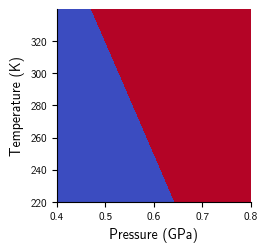

In [11]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))

norm = plt.Normalize(-1e-5, 1e-5)
cf = ax.contourf(gps, gts, gs, cmap="coolwarm", norm=norm)
# cbar = fig.colorbar(cf)

ax.set_xlabel("Pressure (GPa)")
ax.set_ylabel("Temperature (K)")
ax.set_xlim(0.4, 0.8)

# savefig(fig, "02-Sn-PT.pdf")
plt.show()

## Computing the entropy along an isobaric

### First, we use the phase diagram to compute the entropy difference along an isobaric at 0.6 GPa

In [12]:
ts = np.arange(220, 340, 1)
pressure = 0.6  # GPa
isobaric = np.concatenate([
    pressure * np.ones((len(ts), 1)),
    ts.reshape(-1, 1),
], axis=1)

In [13]:
_va = v_alpha_fn(isobaric)
_vb = v_beta_fn(isobaric)

_fa = f_alpha_fn(np.stack([_va, ts.ravel()], axis=1))
_fb = f_beta_fn(np.stack([_vb, ts.ravel()], axis=1))

_ga = _fa + pressure * GPa * _va
_gb = _fb + pressure * GPa * _vb

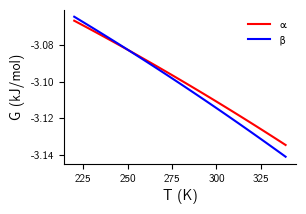

In [14]:
fig, ax = plt.subplots(figsize=(3, 2))

ax.plot(ts.ravel(), _ga, "r-", label="α")
ax.plot(ts.ravel(), _gb, "b-", label="β")

ax.legend(frameon=False)

ax.set_xlabel("T (K)")
ax.set_ylabel("G (kJ/mol)")
plt.show()

In [15]:
_sa = -np.diff(_ga) / np.diff(ts) * kB
_sb = -np.diff(_gb) / np.diff(ts) * kB

In [16]:
dS = pd.DataFrame({
    "a": _sa,
    "b": _sb,
    "dS": _sb - _sa
}, index=ts.ravel()[1:])

### Now, we load the entropies calculated with QUESTS

In [17]:
ha = pd.read_csv(f"{ROOT_DIR}/entropy/alpha.csv", index_col=0).set_index(["temperature", "press"])
hb = pd.read_csv(f"{ROOT_DIR}/entropy/beta.csv", index_col=0).set_index(["temperature", "press"])
dH = hb["entropy"] - ha["entropy"]
dU = hb["energy"] - ha["energy"]
dV = hb["volume"] - ha["volume"]
tp = np.array(ha.index.tolist())

In [18]:
deg = 2
kwargs = {"alpha": 0.0001, "max_iter": 1000000}

v_alpha_fn = PolynomialRegressor2D(deg, tp, ha["volume"].values, **kwargs)
v_beta_fn = PolynomialRegressor2D(deg, tp, hb["volume"].values, **kwargs)
u_alpha_fn = PolynomialRegressor2D(deg, tp, ha["energy"].values, **kwargs)
u_beta_fn = PolynomialRegressor2D(deg, tp, hb["energy"].values, **kwargs)
h_alpha_fn = PolynomialRegressor2D(deg, tp, ha["entropy"].values, **kwargs)
h_beta_fn = PolynomialRegressor2D(deg, tp, hb["entropy"].values, **kwargs)

In [19]:
ntps = np.stack([nts, nps], axis=1)

In [20]:
dv = v_beta_fn(ntps) - v_alpha_fn(ntps)
du = u_beta_fn(ntps) - u_alpha_fn(ntps)
dh = h_beta_fn(ntps) - h_alpha_fn(ntps)

In [21]:
dG = du - (1 / kB) * dh * nts + nps * dv * GPa
dGgrid = dG.reshape(gts.shape)

In [22]:
ours_p, ours_t = find_zero_points(gps, gts, dGgrid, tol=1e-5)

### Plotting

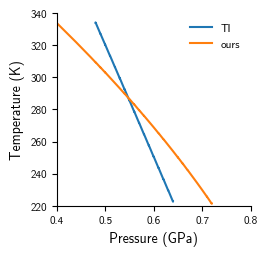

In [23]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))

ax.plot(ti_p, ti_t, label="TI")
ax.plot(ours_p, ours_t, label="ours")
# ax.plot(exp["P"], exp["T"], label="exp")

ax.set_xlabel("Pressure (GPa)")
ax.set_ylabel("Temperature (K)")
ax.set_xlim(0.4, 0.8)
ax.set_ylim(220, 340)

ax.legend(frameon=False)
# savefig(fig, "02-Sn-PT.pdf")
plt.show()

### Comparing with ground truth

In [24]:
mask = gps == 0.6
_t, _dg = gts[mask], dGgrid[mask]

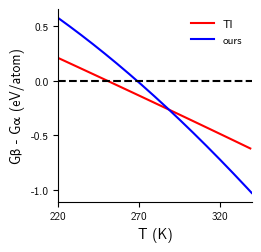

In [25]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))

xlim = [220, 340]

ax.plot(ts.ravel(), (_gb - _ga) / kJ_mol, "r-", label="TI")
ax.plot(_t, _dg / kJ_mol, "b-", label="ours")
ax.plot(xlim, [0, 0], "k--")

ax.legend(frameon=False)

ax.set_xlabel("T (K)")
ax.set_ylabel("Gβ - Gα (eV/atom)")

ax.set_xticks([220, 270, 320])
ax.set_yticks([-1, -.5, 0, 0.5])
ax.set_xlim(*xlim)

# savefig(fig, "02-Sn-dG.pdf")
plt.show()